# Домашние задание по курсу Перенос Обучения
## Урок 2. Representation learning

## Задание №1:
1. Заменить используемую сеть на менее "глубокую"
2. Увеличить размер изображения, задав большее значение чем 256
3. Изменить соотношение стиля и контента
4. Сгенерировать стилизованное изображение, используя другие, выбранные вами изображения

Специальные требования:
- Ноутбук должен выполняться в Colab или в локальном Jupyter нотбуке. Изображения должны быть приложены (например, вклеены в текутовую ячейку), либо должны быть даны ссылки на них (URL).
- Если ноутбук выложен в Colab, не забудьте разрешить к нему доступ. Преподаватель готов подождать получения доступа, но, к сожалению, без доступа, задание будет считаться несданным.
- Скрипт можно выполнять в Jupyter на собственном ПК (в том числе на CPU), а можно в Google Colab.

- Замечание: Иллюстрации первой части ноутбука могут не открываться в Google Colab. И пока мы не оптимизировали ноутбук для Colab, вы можете прочитать теорию в приложенном HTML файле.



## Задания из лекционых материалов:
1. Установите размер изображения равным 512
2. Замените нейросеть на VGG-16
3. Поменяйте вес вклада стиля и контента, в общую лосс-функцию (например, на 1000 к 1)
4. Сгенерируйте собственное NST изображение для выбранных вами входных, контент- и стилевых изображений


## Задания выполнялись паралеьно поскольку они почти полностью схожи
### !!! Задание выполнено в GoogleClolab, сохранено и перенесенов в VSCode, код в самом VSCode не запускался ввиду очень ограниченой мощности моего ноутбука.

In [87]:
# Импортируем библиотеки и модули для работы
# Для работы с нейросетями
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Для работы с изображениями
from PIL import Image
import matplotlib.pyplot as plt
# Оптимизация и преобразования изображения
import torchvision.transforms as transforms
# Переобучение модели
from torchvision.models import vgg16, VGG16_Weights
# Для создания копии объёектов
import copy

In [88]:
# Проверяем, что мы переключились на GPU ввиду того, что на cuda процесс проходит намного быстрее чем на CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

In [89]:
# Выбираем размер изображения которое мы хотим обрабатывать
# По заданию работаем с изображением больше чем 256 и так же соблюдаем условие из лекторского задания и устанавливаем 512, если GPU ядра не будут обнаружены тогда изображение будет уменьшено до 256
imsize = 512 if torch.cuda.is_available() else 256

loader = transforms.Compose([
    # Создаём пайплайн масштабируем с сохранением соотношения сторон
    transforms.Resize(imsize),
    # Обрезаем по краям чтобы получить квадратное изображение
    transforms.CenterCrop(imsize),
    # Преобразуем в нужный нам класс тензер – Torch Tensor
    transforms.ToTensor()])

In [90]:
# Нейросеть ждет не одну картинку, а набор картинок
# поэтому нужно добавить к изображению одно мнимое измерение
# (количество картинок в батче всегда будет равно 1)

# Функция загрузки изображения и конвертации изображения
def image_loader(image_name):
    # Загрузим и преобразуем картинку, если она в оттенках серого или с альфа-каналом и тд.
    image = Image.open(image_name).convert('RGB')
    # Добавляем мнимое четвёртое измерение
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Загружаем сами картинки
style_img_1 = image_loader("./images/picasso.jpg")
content_img_1 = image_loader("./images/macarons.jpg")

style_img_2 = image_loader("./images/image_2.jpg")
content_img_2 = image_loader("./images/image_1.jpg")

# Проверка
assert style_img_1.size() == content_img_1.size() and style_img_2.size() == content_img_2.size(),\
    "Изображения должны быть одинакового размера, что-то пропущено в процедуре подготовки изображений"

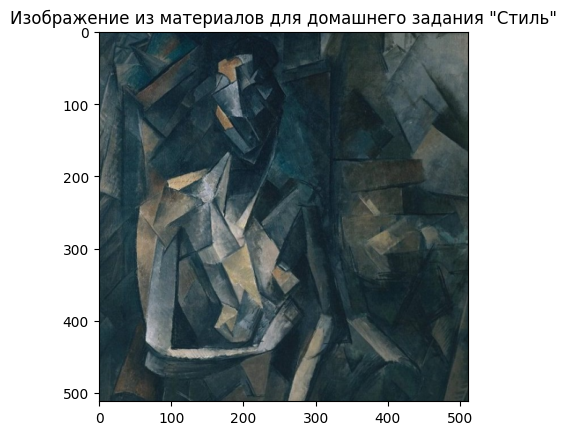

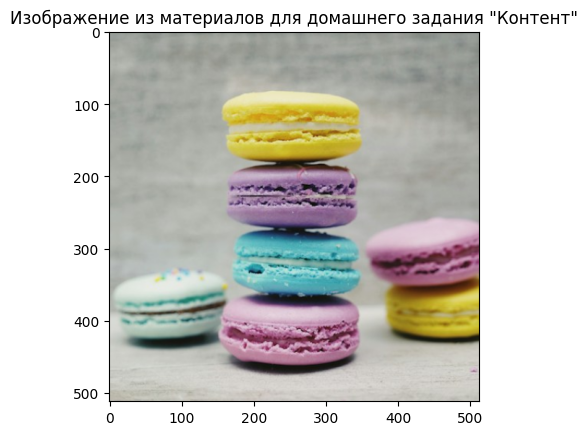

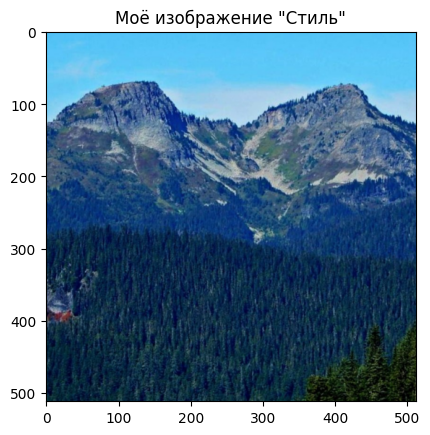

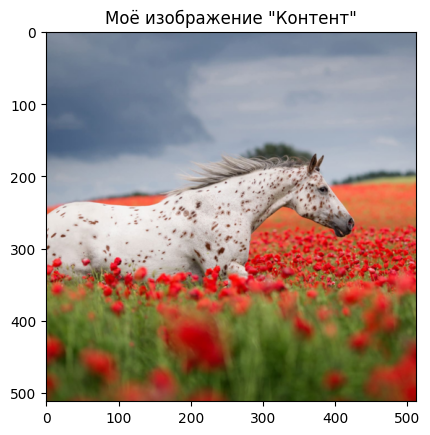

In [91]:
# Преобразуем в картинку PIL
unloader = transforms.ToPILImage()
plt.ion()

# Функция которая выводит изображение
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # создаем копию тензора чтобы не менять исходный
    image = image.squeeze(0)      # устраняем лишнее измерение (которое делало батч из изображения)
    image = unloader(image)
    plt.imshow(image)

    if title is not None:
        plt.title(title)
    plt.pause(0.001) # Дадим графику обновиться

# Добавляем название изображению
plt.figure()
imshow(style_img_1, title='Изображение из материалов для домашнего задания "Стиль"')

plt.figure()
imshow(content_img_1, title='Изображение из материалов для домашнего задания "Контент"')

plt.figure()
imshow(style_img_2, title='Моё изображение "Стиль"')

plt.figure()
imshow(content_img_2, title='Моё изображение "Контент"')

In [92]:
# Функция измеряет расстояние между двумя изображениями в части содержимого изображения
class ContentLoss(nn.Module):
# Необходимо "отвязать" (detach) набор целевых признаков (target content)
# от других объектов, которые находят его градиент. Это статический объект
# Если этого не сделать, метод forward вернут нам ошибку
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    # Вычисляет активации, сигналы которые передаются между всеми слоями нейросети
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [93]:
# Расхождение по стилю, функция для матрицы грамма
def gram_matrix(input):
    # a = размер батча(= 1)
    # b = количество карт признаков, для которых мы считаем матрицу
    # (c, d) = размерность карты признаков f (N = c * d)
    a, b, c, d = input.size()

    # изменим размерность матрицы F_XL, получим \hat F_XL
    features = input.view(a * b, c * d)

    # Рассчитываем произведение матриц чтобы получить матрицу Грама
    G = torch.mm(features, features.t())

    # Нормализуем значения матрицы Грама, разделив значения матрицы на количество элементов
    return G.div(a * b * c * d)

In [94]:
# Функция потерь для стиля, расчет расстоняи по стилю между двумя изображениями
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # Грамм матрица целевого изображения
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        # Грамм матрица входного изображения
        self.loss = F.mse_loss(G, self.target)
        return input

In [95]:
# Загрузим нейроную модель VGG16 вместо VGG19 тем самым выполнения совподающие задания
# Параметр ".eval()" запрещает модели обучаться, замораживает все параметры слоёв
cnn = vgg16(weights=VGG16_Weights.DEFAULT).features.eval()

In [96]:
# Нормализация входных изображений, коффэценты стандартные но их можно поменять
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# Упаковочный класс, чтобы картинку было легче передать в объект ``nn.Sequential``
class Normalization(nn.Module):
        # Преобразуем мат.ожидание и дисперсию при помощи .view так, чтобы
        # их можно было легко умножить на тензор с картинкой
        # Картинка имеет размерность [B x C x H x W]
        # Мы приводим коэффициенты нормализации к размерности [C x 1 x 1]
        # B – размер батча. C – количество каналов. H – высота, W – ширина изображения.
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # нормализуем изображение ``img``
        return (img - self.mean) / self.std

In [97]:
# Смотрим слои нейросети, видим что у слоёв нету названий
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [98]:
# Названия слоев, где мы будем рассчитывать расхождение по контенту
content_layers_default = ['conv_4']
# Если мы поймали иснтанс пулинга
# content_layers_default = ['pool_4']

# Названия слоев, где мы будем рассчитывать расхождение по стилю
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # Модуль чтобы нормализоавть изображения
    normalization = Normalization(normalization_mean, normalization_std)

    # Будем складывать меры расхождения (лоссы) в удобные массивы
    content_losses = []
    style_losses = []

    # Поскольку ``cnn`` является объектом типа ``nn.Sequential``,
    # Создадим новый ``nn.Sequential`` куда мы по порядку положим
    # Все модули, которые будут проводить вычисления в нейросети
    model = nn.Sequential(normalization)

    i = 0  # пройдемся по элементам в исходной нейросети и дадим им имена
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # Чуть изменим параметры слоев активации (версия которая использована
            # в исходной нейросети не работает с нашей реализацией ``ContentLoss`` и ``StyleLoss``)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # Добавим очередной модуль в нашу Sequential-модель
        model.add_module(name, layer)

        if name in content_layers:
            # Если к последнему слою нужно пристыковать контент-лосс, сделаем это
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # Если имя слоя в списке стиль-лоссов, добавим после него соответствующий лосс
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Все слои которые идут после последнего добавленного контент-лосса или стиль-лосса
    # нам будут не нужны, их можно отбросить
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

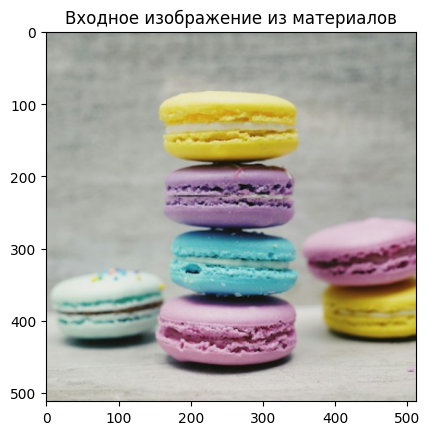

In [124]:
# Чтобы использовать исходную картинку, раскомментируйте:
input_img = content_img_1.clone()

# Чтобы использовать шум
# input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Входное изображение из материалов')

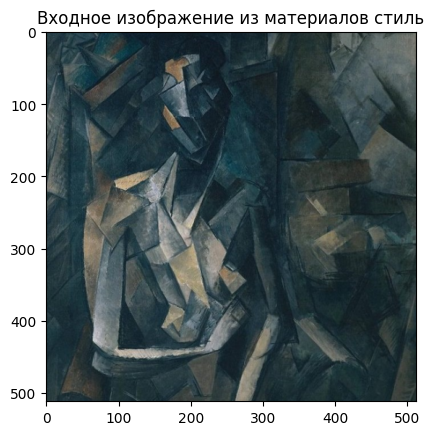

In [125]:
# Чтобы использовать исходную картинку, раскомментируйте:
input_img_s = style_img_1.clone()

# Чтобы использовать шум
# input_img = torch.randn(style_img_1.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img_s, title='Входное изображение из материалов стиль')

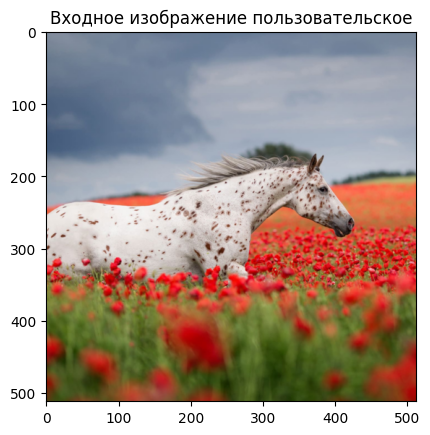

In [126]:
# Чтобы использовать исходную картинку, раскомментируйте:
input_img_p = content_img_2.clone()

# Чтобы использовать шум
# input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img_p, title='Входное изображение пользовательское')

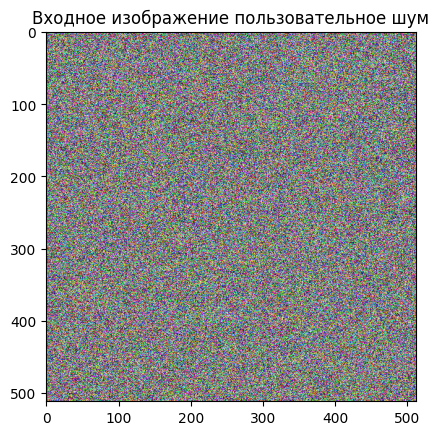

In [135]:
# Чтобы использовать исходную картинку, раскомментируйте:
# input_img_sh = style_img_2.clone()

# Чтобы использовать шум
input_img_sh = torch.randn(style_img_2.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img_sh, title='Входное изображение пользовательное шум')

In [136]:
# Градиентный спуск, оптимизатор
def get_input_optimizer(input_img):
  # LBFGS должен работать лучше чем другие методы градиентного спуска
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [137]:
# Функция изменения характера оптимизация стиля и контента, здесь мы изменяем значения согласно заданию
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=600, # num_steps 300 шагов оптимизации больше шагов больше качество
                       style_weight=1000, content_weight=1):

    print('Построение модели переноса стиля..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # Укажем, какой объект мы будем оптимизировать (включить параметр requires_grad fields)
    input_img.requires_grad_(True)
    # Переключим модель в режим исполнения, чтобы заморозить слои вроде dropout или батч нормализации normalization layers
    model.eval()
    # Очевидно, мы не будем оптимизировать модель, так что заморозим все параметры
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Оптимизируем картинку..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # Скорректируем значения входного изображения
            with torch.no_grad():
                input_img.clamp_(0, 1)

            # Обнуляем градиенты (иногда их используют между итерациями, но не сейчас)
            optimizer.zero_grad()
            # Отправляем картинку в модель
            model(input_img)

            # Посчитаем расхождение изображений по стилю и содержимому
            style_score = 0
            content_score = 0

            for sl in style_losses: style_score += sl.loss
            for cl in content_losses: content_score += cl.loss

            # Домножаем каждую компоненту лосса на заданный вес
            style_score *= style_weight
            content_score *= content_weight

            # И по этому значению осуществляем обратное распространение ошибки (обратно по сети, вплоть до изображения)
            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # Вернем изображение в диапазон
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Построение модели переноса стиля..
Оптимизируем картинку..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


run [50]:
Style Loss : 1.044988 Content Loss: 0.379401

run [100]:
Style Loss : 0.997197 Content Loss: 0.392283

run [150]:
Style Loss : 0.967414 Content Loss: 0.399693

run [200]:
Style Loss : 0.945839 Content Loss: 0.405181

run [250]:
Style Loss : 0.927326 Content Loss: 0.409121

run [300]:
Style Loss : 0.908997 Content Loss: 0.414252

run [350]:
Style Loss : 0.888765 Content Loss: 0.424261

run [400]:
Style Loss : 0.857379 Content Loss: 0.476669

run [450]:
Style Loss : 0.842150 Content Loss: 0.470786

run [500]:
Style Loss : 0.829792 Content Loss: 1.404829

run [550]:
Style Loss : 0.815718 Content Loss: 0.682429

run [600]:
Style Loss : 0.805763 Content Loss: 0.593807



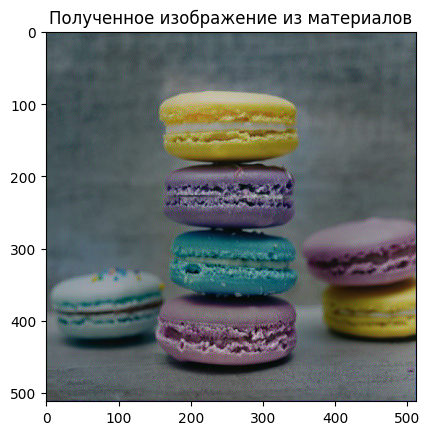

In [131]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_1, style_img_1, input_img)

plt.figure()
imshow(output, title='Полученное изображение из материалов')

plt.ioff()
plt.show()

Построение модели переноса стиля..
Оптимизируем картинку..
run [50]:
Style Loss : 249.445084 Content Loss: 249.635025

run [100]:
Style Loss : 148.604996 Content Loss: 184.875992

run [150]:
Style Loss : 86.931175 Content Loss: 183.136841

run [200]:
Style Loss : 56.553574 Content Loss: 200.683243

run [250]:
Style Loss : 44.698799 Content Loss: 187.952057

run [300]:
Style Loss : 40.007759 Content Loss: 177.517624



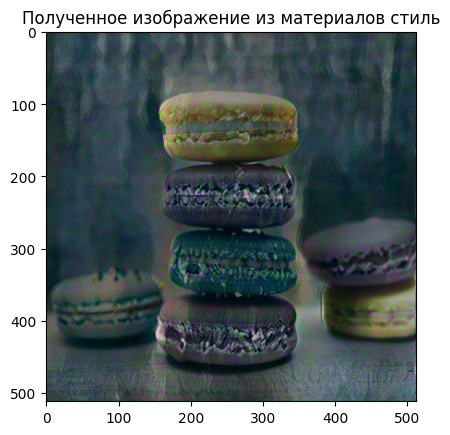

In [147]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_1, style_img_1, input_img_s, num_steps=300, style_weight=1000000, content_weight=50)

plt.figure()
imshow(output, title='Полученное изображение из материалов стиль')

plt.ioff()
plt.show()

Построение модели переноса стиля..
Оптимизируем картинку..
run [50]:
Style Loss : 1.879761 Content Loss: 1.476638

run [100]:
Style Loss : 1.732010 Content Loss: 1.288359

run [150]:
Style Loss : 1.497791 Content Loss: 1.383065

run [200]:
Style Loss : 1.417325 Content Loss: 1.602708

run [250]:
Style Loss : 1.324220 Content Loss: 1.484920

run [300]:
Style Loss : 1.301004 Content Loss: 1.548776

run [350]:
Style Loss : 1.306547 Content Loss: 1.625674

run [400]:
Style Loss : 1.319934 Content Loss: 1.679016

run [450]:
Style Loss : 1.353747 Content Loss: 1.753850

run [500]:
Style Loss : 1.342299 Content Loss: 1.758103

run [550]:
Style Loss : 1.348115 Content Loss: 1.865067

run [600]:
Style Loss : 1.624453 Content Loss: 2.158651



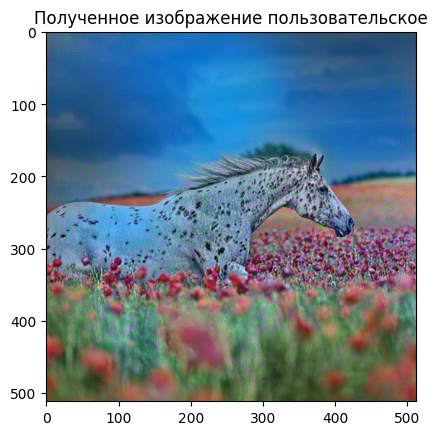

In [133]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_2, style_img_2, input_img_p)

plt.figure()
imshow(output, title='Полученное изображение пользовательское')

plt.ioff()
plt.show()

Построение модели переноса стиля..
Оптимизируем картинку..
run [50]:
Style Loss : 4.832876 Content Loss: 9.447676

run [100]:
Style Loss : 2.619706 Content Loss: 6.158654

run [150]:
Style Loss : 828.844360 Content Loss: 45.608650

run [200]:
Style Loss : 258108.578125 Content Loss: 474.094116

run [250]:
Style Loss : 15.109172 Content Loss: 11.418114

run [300]:
Style Loss : 2.437272 Content Loss: 7.884334



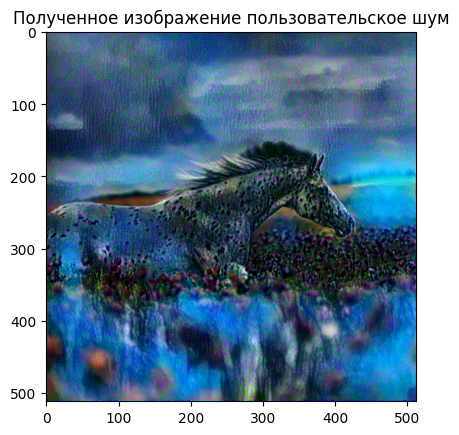

In [145]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_2, style_img_2, input_img_sh, num_steps=300, style_weight=10000, content_weight=1)

plt.figure()
imshow(output, title='Полученное изображение пользовательское шум')

plt.ioff()
plt.show()